In [7]:
import torch 
import torch.nn as nn
import numpy as np

import os
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation # to plot animations
from IPython import display #same

In [12]:
def grid_encoding(functions, x_coordinates, encoding_dimension):
    """ 
    This function reduces the size of a the input tensor functions and the corresponding x_coordinates to a lower size (encodinf_dimension) according the x dimension

    :param functions: this is a tensor of dimension (P, M) representing a 1D function u evolving through time, each coordinate (i,j) corresponds to a location x_i and a time t_j i.e function[i,j] = u(x_i, t_j)
    :param x_coordinates: this is a tensor of dimension (P,) representing the points (x_i) where the function u has been evaluated.
    :param encoding_dimension: this is an integer descibing the new size of the x axis 

    :return encoding_coordinates: tensor of dimension (encoding_dimension,) representing the x points where the functions is now evaluated
    :return encoded_functions: tensor of dimension (encoding_dimension, M) representing the functions on a lower space.
    """
    P = functions.shape[0]
    M = functions.shape[1]
    
    idx = np.linspace(0, P-1, encoding_dimension)
    encoded_functions = functions[idx, :]
    encoding_coordinates = x_coordinates[idx]
    

In [18]:
m = 256
nu = 0.7


data = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/data_"+str(int(100*nu))+".npy"))).type(torch.float32)
mat_deriv = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/mat_deriv_"+str(int(100*nu))+".npy"))).type(torch.float32)
grid_carac = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/grid_"+str(int(100*nu))+".npy"))).type(torch.float32)
nt, dt, Tf, Mx, dx, L = grid_carac
u_train = data[:,100:]
mat_deriv_train = mat_deriv[:,100:]

x_coordinates = torch.arange(0., Mx)*dx # reconstruction of the vector encoding the coordinates used for x

n_train = u_train.shape[1]

x_encoded, encoded_input_train = grid_encoding(u_train, x_coordinates, encoding_dimension=m)
encoded_input_train = encoded_input_train.T

_, encoded_output_train = grid_encoding(mat_deriv_train, x_coordinates, encoding_dimension=m)
encoded_output_train = encoded_output_train.T


data = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/data_"+str(int(100*nu))+"_test.npy"))).type(torch.float32)
mat_deriv = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/mat_deriv_"+str(int(100*nu))+"_test.npy"))).type(torch.float32)
grid_carac = torch.from_numpy(np.load(os.path.join(os.path.abspath(''), "../data/ks_equation/grid_"+str(int(100*nu))+"_test.npy"))).type(torch.float32)
nt, dt, Tf, Mx, dx, L = grid_carac
u_test = data[:,100:]
mat_deriv_test = mat_deriv[:,100:]

x_coordinates = torch.arange(0., Mx)*dx # reconstruction of the vector encoding the coordinates used for x

n_test = u_test.shape[1]

_, encoded_input_test = grid_encoding(u_test, x_coordinates, encoding_dimension=m)
encoded_input_test = encoded_input_test.T

_, encoded_output_test = grid_encoding(mat_deriv_test, x_coordinates, encoding_dimension=m)
encoded_output_test = encoded_output_test.T



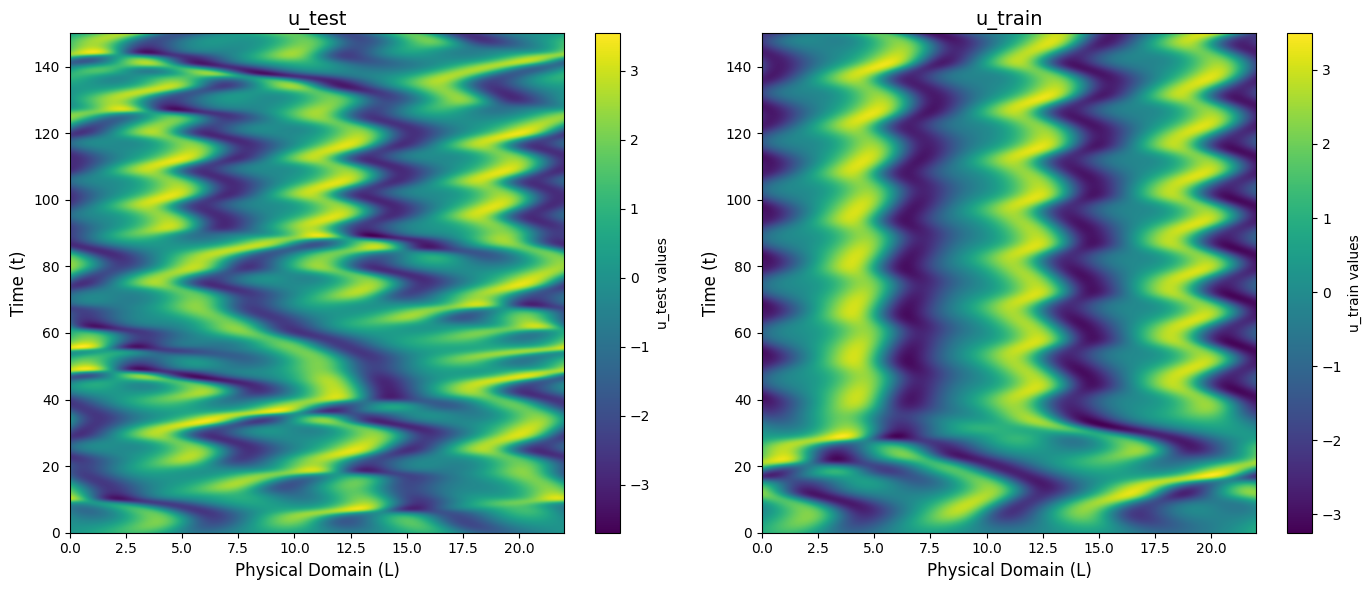

In [28]:
import matplotlib.pyplot as plt

# Définir les dimensions du domaine physique et du temps
L = 22  # Domaine physique
T = 150  # Temps

# Générer les coordonnées physiques et temporelles
x = torch.linspace(0, L, u_test.shape[0])  # Domaine physique
t = torch.linspace(0, T, u_test.shape[1])  # Temps

# Créer les sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Afficher u_test (inversé avec u_train)
im1 = axs[0].imshow(u_test.T, extent=[0, L, 0, T], aspect='auto', origin='lower', cmap='viridis')
axs[0].set_title("u_test", fontsize=14)
axs[0].set_xlabel("Physical Domain (L)", fontsize=12)
axs[0].set_ylabel("Time (t)", fontsize=12)
fig.colorbar(im1, ax=axs[0], orientation='vertical', label="u_test values")

# Afficher u_train (inversé avec u_test)
im2 = axs[1].imshow(u_train.T, extent=[0, L, 0, T], aspect='auto', origin='lower', cmap='viridis')
axs[1].set_title("u_train", fontsize=14)
axs[1].set_xlabel("Physical Domain (L)", fontsize=12)
axs[1].set_ylabel("Time (t)", fontsize=12)
fig.colorbar(im2, ax=axs[1], orientation='vertical', label="u_train values")

# Ajuster la mise en page
plt.tight_layout()
plt.show()

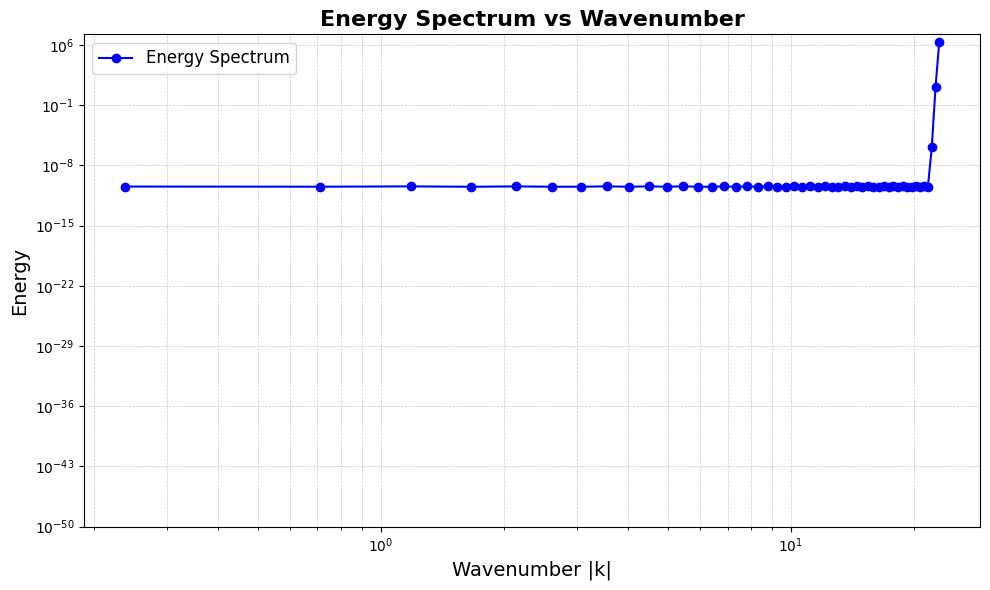

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Si u_test est un tenseur PyTorch, convertissez-le en tableau numpy
if isinstance(u_test, torch.Tensor):
    u_test = u_test.numpy()

# Dimensions physiques
Lx = 22  # Domaine physique (longueur en x)

# Taille des données
nx, nt = u_test.shape  # nx: nombre de points spatiaux, nt: nombre de snapshots temporels

# Résolution spatiale
dx = Lx / nx

# Fréquences spatiales
kx = np.fft.fftfreq(nx, d=dx)  # Fréquences spatiales
kx = np.fft.fftshift(kx)  # Centrer les fréquences

# Appliquer la FFT 1D sur la première dimension (x) pour chaque snapshot temporel
fft_u = np.fft.fft(u_test, axis=0)  # FFT sur la dimension x
energy_spectrum = np.abs(fft_u)**2  # Calculer l'énergie spectrale

# Moyenne sur la deuxième dimension (t)
energy_spectrum_mean = np.mean(energy_spectrum, axis=1)  # Moyenne sur les snapshots temporels

# Centrer les spectres d'énergie et les fréquences
energy_spectrum_mean = np.fft.fftshift(energy_spectrum_mean)

# Regrouper les énergies par bins de wavenumber
k_bins = np.linspace(0, np.max(kx), num=50)  # Définir les bins pour k
k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])  # Centres des bins
energy_binned, _ = np.histogram(np.abs(kx), bins=k_bins, weights=energy_spectrum_mean)

# Afficher le spectre d'énergie moyen en fonction des wavenumbers
plt.figure(figsize=(10, 6))
plt.loglog(k_bin_centers, energy_binned, marker='o', linestyle='-', color='b', label='Energy Spectrum')
plt.xlabel('Wavenumber |k|', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Energy Spectrum vs Wavenumber', fontsize=16, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.ylim(bottom=1e-50)  # Ajuster la limite inférieure de l'axe y pour une meilleure visibilité
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [60]:
def compute_classical_energy_spectrum(u):
    """
    Spectre classique par FFT directe des composantes de vitesse
    u : ndarray (t, nx, ny, 2)
    Returns: k_vals_classical, E_k_classical
    """
    nx, tsteps = u.shape
    E_k_sum = 0.0

    for t in range(tsteps):
        ux = u[:,t]

        uxf = np.fft.fft(ux)
        E2D = 0.5 * (np.abs(uxf)**2) / (nx)
        E2D = np.fft.fftshift(E2D)

        # Build radial wavenumber grid
        kx = np.fft.fftshift(np.fft.fftfreq(nx)) * nx
        k_mag = np.sqrt(kx**2)

        k_max = int(np.max(k_mag))
        E_k = np.zeros(k_max)
        for i in range(k_max):
            mask = (k_mag >= i) & (k_mag < i + 1)
            E_k[i] += np.sum(E2D[mask])

        E_k_sum += E_k

    E_k_classical = E_k_sum / tsteps
    k_vals_classical = np.arange(len(E_k_classical))
    return k_vals_classical, E_k_classical

In [69]:
k_vals , E_k = compute_classical_energy_spectrum(u_train)

cumulative_energy = np.sqrt(np.cumsum(E_k))
total_energy = cumulative_energy[-1]
normalized_cumulative_energy = cumulative_energy / total_energy


In [70]:
target_energy_fractions = [0.70, 0.80, 0.85, 0.90, 0.95, 0.99, 0.999,0.9999, 0.99999,0.999999]
k_target_values = [k_vals[np.searchsorted(normalized_cumulative_energy, target_energy_fraction)] for target_energy_fraction in target_energy_fractions]

k_targets = dict(zip(target_energy_fractions, k_target_values))
k_targets


{0.7: 3,
 0.8: 3,
 0.85: 3,
 0.9: 4,
 0.95: 5,
 0.99: 6,
 0.999: 8,
 0.9999: 9,
 0.99999: 11,
 0.999999: 12}

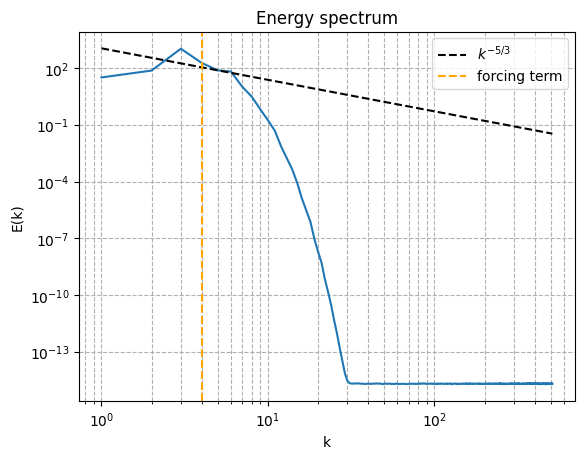

In [68]:
plt.loglog(k_vals[1:],E_k[1:])

k0_index = 5 # Choisis un index dans la zone inertielle
k0 = k_vals[k0_index]
E0 = E_k[k0_index]

# Construire la pente -5/3 à partir de ce point
k_ref = np.linspace(min(k_vals)+1, max(k_vals), 100)
pente = -5/3
C = E0 * k0**(-pente)  # Normalisation pour que la droite passe par (k0, E0)
E_ref = C * k_ref**pente

plt.loglog(k_ref, E_ref, 'k--', label=r'$k^{-5/3}$')
plt.axvline(4, color='orange', linestyle='--', label="forcing term")

# Finitions
plt.xlabel('k')
plt.ylabel('E(k)')
plt.legend()
plt.grid(True, which='both', ls='--')

plt.title('Energy spectrum')
plt.show()